# Experimento epsilon-greedy

<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación del entorno


In [21]:
# Configurar el path para imports
import sys
import os

# Añadir el directorio k_brazos al path de Python
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
k_brazos_dir = notebook_dir if 'k_brazos' in notebook_dir else os.path.join(notebook_dir, 'k_brazos')
if k_brazos_dir not in sys.path:
    sys.path.insert(0, k_brazos_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Added to path: {k_brazos_dir}")

Working directory: C:\Users\dieve\PycharmProjects\EscuderoRodriguezSanchez\k_brazos
Added to path: C:\Users\dieve\PycharmProjects\EscuderoRodriguezSanchez\k_brazos


In [22]:
#@title Importamos todas las clases y funciones
from src.algorithms.algorithm import Algorithm
from src.algorithms.epsilon_greedy import EpsilonGreedy
from src.algorithms.softmax import Softmax
from src.algorithms.ucb1 import UCB1

import numpy as np
from typing import List

from src.arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics

from k_brazos.src.utils import SEMILLA, K, STEPS, RUNS

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 2000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [23]:
# Parámetros del experimento
np.random.seed(SEMILLA)  # Fijar la semilla para reproducibilidad



# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [
    EpsilonGreedy(k=K, epsilon=0),
    EpsilonGreedy(k=K, epsilon=0.01),
    EpsilonGreedy(k=K, epsilon=0.1),
]

## Ejecución del experimento con distribución Normal

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 2000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [24]:
from k_brazos.src.run_experiment import run_experiment

# Creación del bandit
bandido = Bandit(arms=ArmNormal.generate_arms(K)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_normal, optimal_selections_normal, arm_stats_normal = run_experiment(bandido, algorithms, STEPS, RUNS)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados distribución Normal

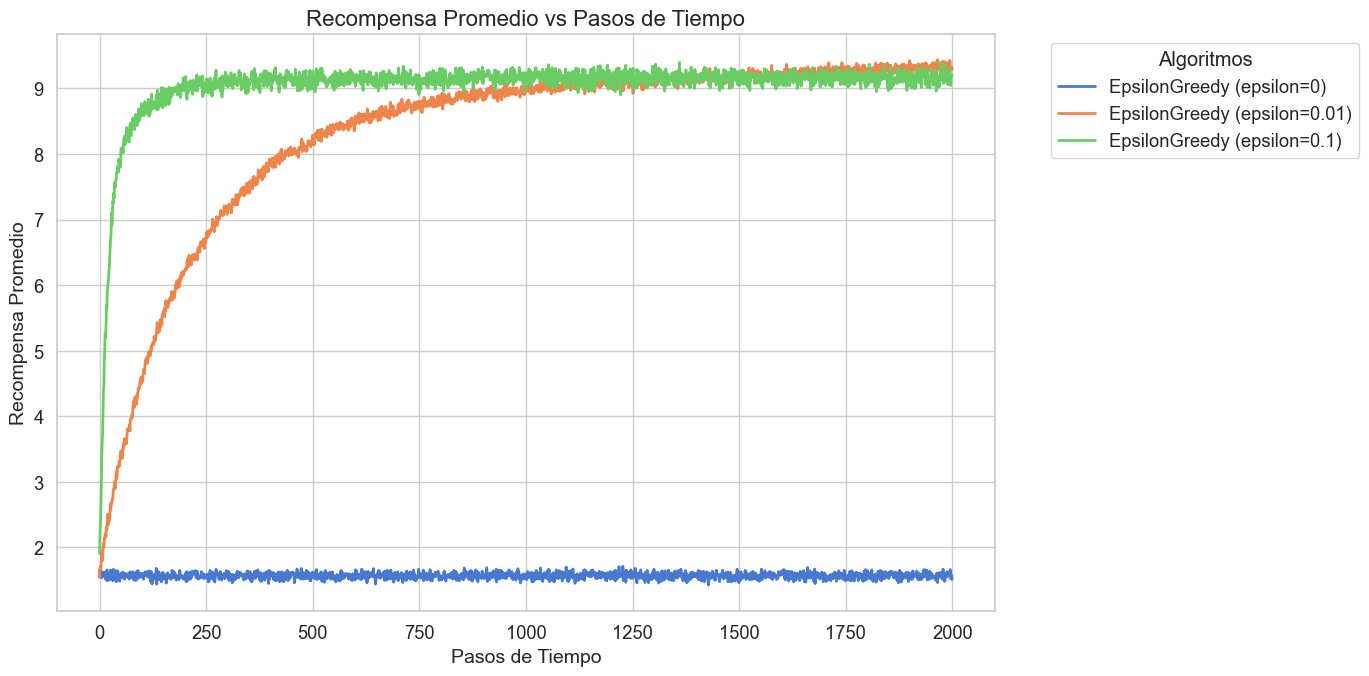

In [25]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_normal, algorithms)


### Análisis del Algoritmo e-greedy (Distribución Normal)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 2000 pasos, comparando diferentes niveles de probabilidad de exploración (e).

* **e=0 (Greedy):** Presenta el peor rendimiento, estancándose prematuramente en una recompensa cercana a 1.5. Al no explorar, el algoritmo selecciona el primer brazo con retorno positivo y queda atrapado en un óptimo local, ignorando brazos con medias superiores.

* **e=0.1:** Es el más eficiente en el corto plazo, logrando la mayor pendiente de aprendizaje inicial. Alcanza un estado estacionario (aprox. 9.2 de recompensa) alrededor del paso 200, demostrando que una exploración constante permite identificar rápidamente los mejores brazos.

* **e=0.01:** Muestra un aprendizaje más lento pero constante. Aunque tarda más en identificar el brazo óptimo debido a su baja tasa de exploración, supera a e=0.1 a partir de los 1500 pasos, ya que incurre en menos "pérdida por exploración" una vez que el conocimiento del entorno es preciso.

---


In [26]:
if optimal_selections_normal is not None and len(optimal_selections_normal) > 0:
    print(f"optimal selections: {optimal_selections_normal}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.79  0.78  0.786]
 [0.01  0.02  0.022 ... 0.908 0.924 0.914]]


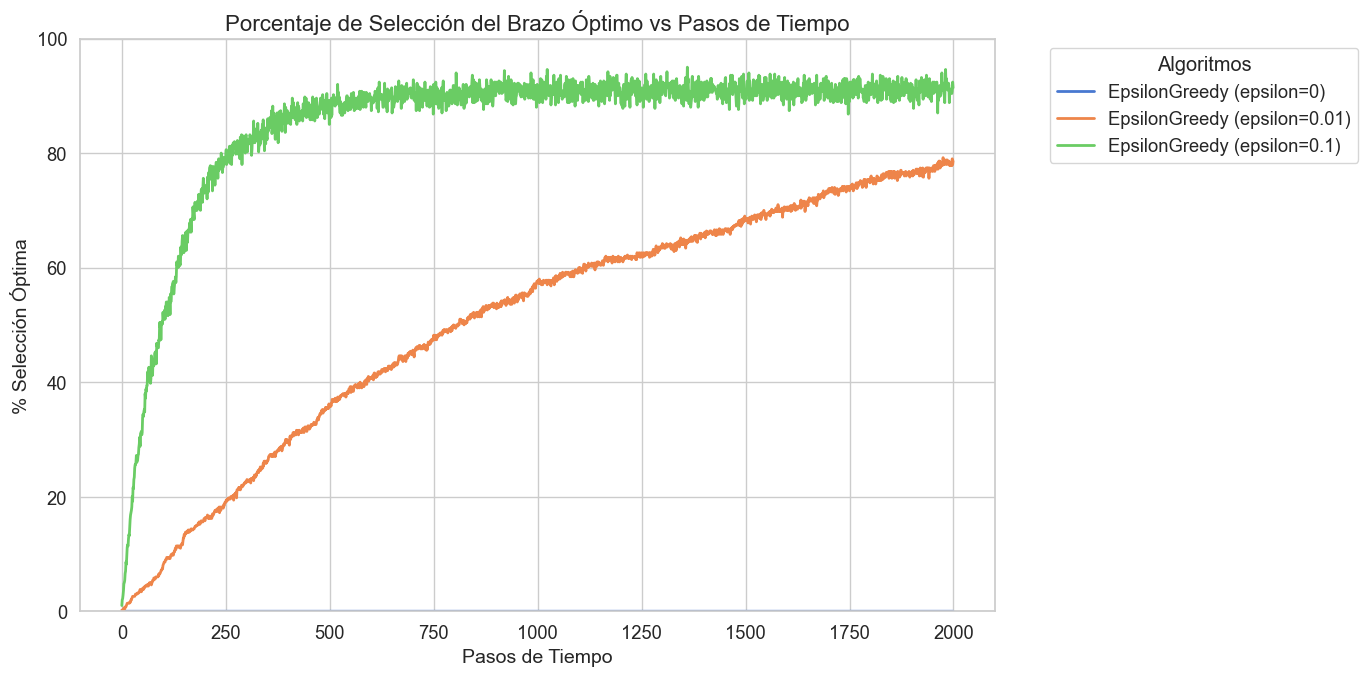

In [27]:
plot_optimal_selections(STEPS, optimal_selections_normal, algorithms)

Porcentaje de Selección del Brazo Óptimo

- **e = 0.1**: Sobresale al identificar y seleccionar la acción óptima en más del 80% de las ocasiones antes del paso 400, llegando a estabilizarse cerca del 90%.

- **e = 0.01**: Al finalizar los 2000 pasos, apenas alcanza un 80% de selección óptima. Esto confirma que, si bien es más conservador, requiere de un horizonte temporal mucho mayor para converger hacia el brazo ideal.

- **e = 0**: Su porcentaje de selección óptima permanece, no se observa, pero se asume en torno a 0. Esto demuestra que la probabilidad de seleccionar el mejor brazo por pura suerte inicial es mínima sin una estrategia de exploración.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

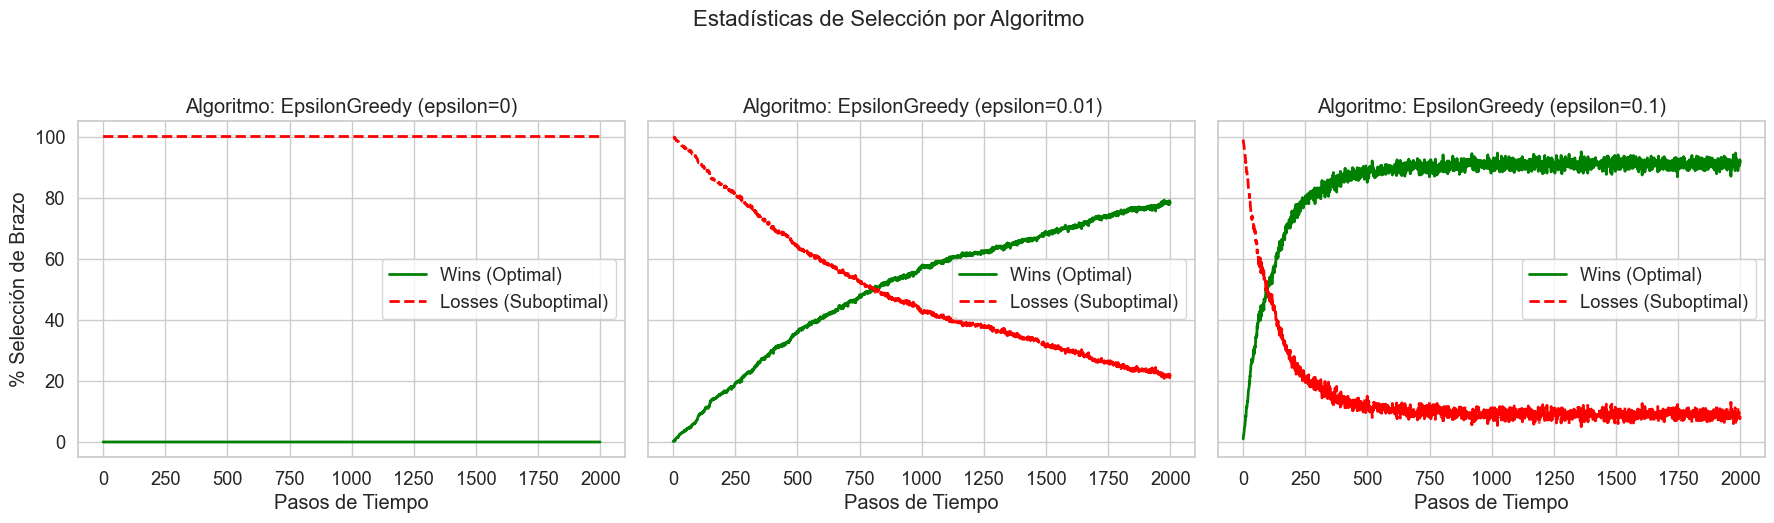

In [28]:
plot_arm_statistics(arm_stats_normal, algorithms)

En la gráfica anterior representamos los diferentes parámetros de los algoritmos epsilon-greedy en el experimento sobre distribución normal. Se puede observar que considerando `wins` como la elección del brazo correcto y `losses` como la elección del brazo incorrecto, el algoritmo con `epsilon=0.1` es el que más veces selecciona el brazo óptimo, mientras que el algoritmo con `epsilon=0` es el que menos veces lo hace, al igual que con las recompensas obtenidas, el algoritmo `epsilon=0.01` presenta un crecimiento más lento pero más estable.

Por otro lado, dado que *losses* es no aceptar el brazo que genera recompensa, podríamos decir que obtener los resultados de losses es lo mismo que hacer 1-wins, por lo que consideramos que podríamos eliminar su cálculo de la función run_experiment para evitar el coste del cálculo, aunque lo mantendremos para justificar esta afirmación.




## Ejecución del experimento sobre distribución Binomial

En este experimento al igual que el anterior usamos 10 brazos, para mantener el mismo experimento que para el caso de distribución normal, pero utilizando una distribución binomial. Se realizan 500 ejecuciones de 2000 pasos cada una. Al igual que en el experimento anterior se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [29]:
# Creación del bandit
bandido = Bandit(arms=ArmBinomial.generate_arms(K)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_binomial, optimal_selections_binomial, arm_stats_binomial = run_experiment(bandido, algorithms, STEPS, RUNS)


Bandit with 10 arms: ArmBinomial(n=10, p=0.68), ArmBinomial(n=10, p=0.08), ArmBinomial(n=10, p=0.78), ArmBinomial(n=10, p=0.29), ArmBinomial(n=10, p=0.06), ArmBinomial(n=10, p=0.98), ArmBinomial(n=10, p=0.49), ArmBinomial(n=10, p=0.97), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.09)
Optimal arm: 6 with expected reward=9.83912564058675


### Visualización de los resultados del experimento Binomial

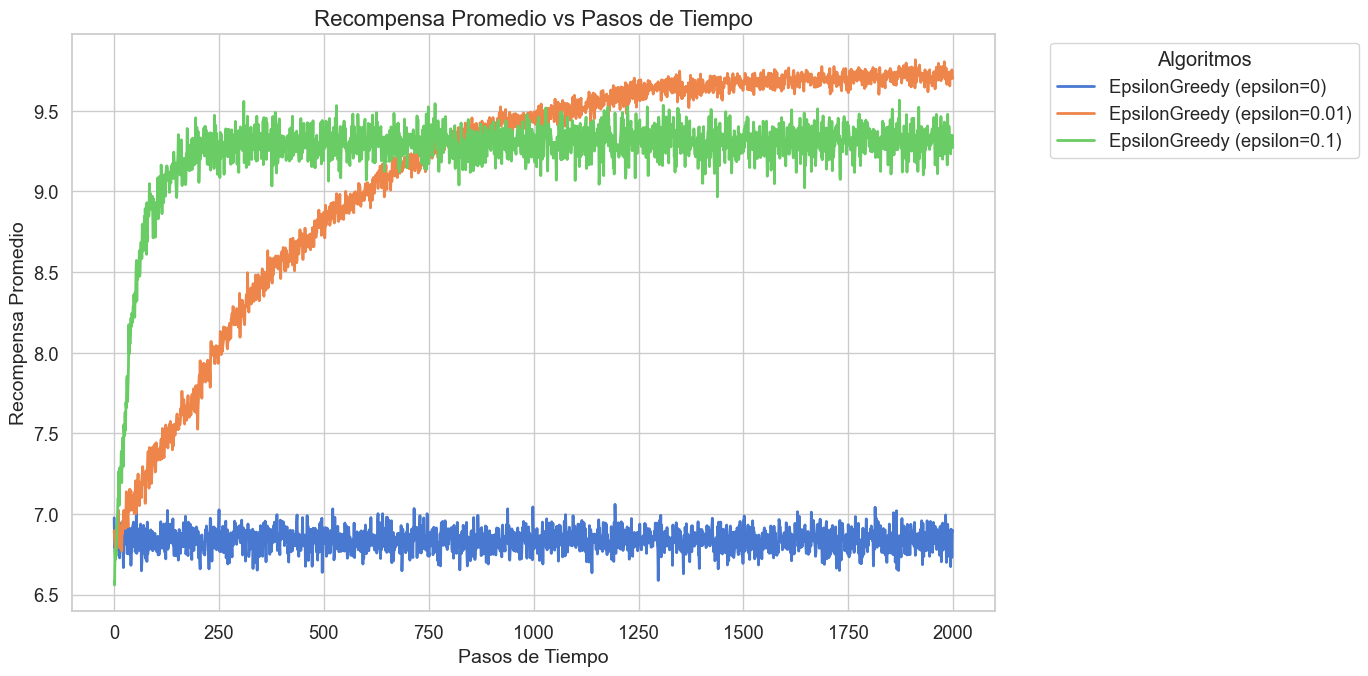

In [30]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_binomial, algorithms)

El rendimiento del algoritmo sobre brazos con distribución binomial muestra dinámicas de exploración-explotación similares a la distribución normal, pero con una convergencia a valores de recompensa más altos debido a la naturaleza de la distribución B(n,p).

* **e = 0 (Greedy):** Muestra el rendimiento más bajo, estancándose en una recompensa promedio cercana a **6.75**. Al carecer de exploración, el algoritmo selecciona un brazo subóptimo basándose en las primeras impresiones y nunca descubre los brazos con mayor probabilidad de éxito (p), quedando atrapado permanentemente en un óptimo local.
* **e = 0.1 (Exploración alta):** Es el más rápido en aprender inicialmente, alcanzando una recompensa de **9.3** en apenas 250 pasos. Sin embargo, su rendimiento se mantiene plano y con mucho "ruido" (fluctuaciones) durante el resto de la simulación. Esto ocurre porque sigue eligiendo brazos aleatorios el 10% de las veces, lo que le impide estabilizarse en el valor máximo teórico.
* **e = 0.01 (Exploración baja):** Es el claro ganador a largo plazo. Aunque su ascenso es más lento, logra superar a e=0.1 alrededor del paso 750, alcanzando una recompensa superior a **9.7** a partir del paso 1500. Al explorar solo el 1% de las veces, aprovecha mucho mejor el brazo óptimo una vez identificado, minimizando las pérdidas por decisiones aleatorias.

Los resultados obtenidos sugieren que realizar una exploración alta es excelente al principio del aprendizaje, pero que una exploración moderada es necesaria para alcanzar un rendimiento óptimo a largo plazo.

---

In [31]:
print(f"optimal selections: {optimal_selections_binomial}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.002 0.002 ... 0.722 0.718 0.722]
 [0.016 0.026 0.038 ... 0.9   0.894 0.892]]


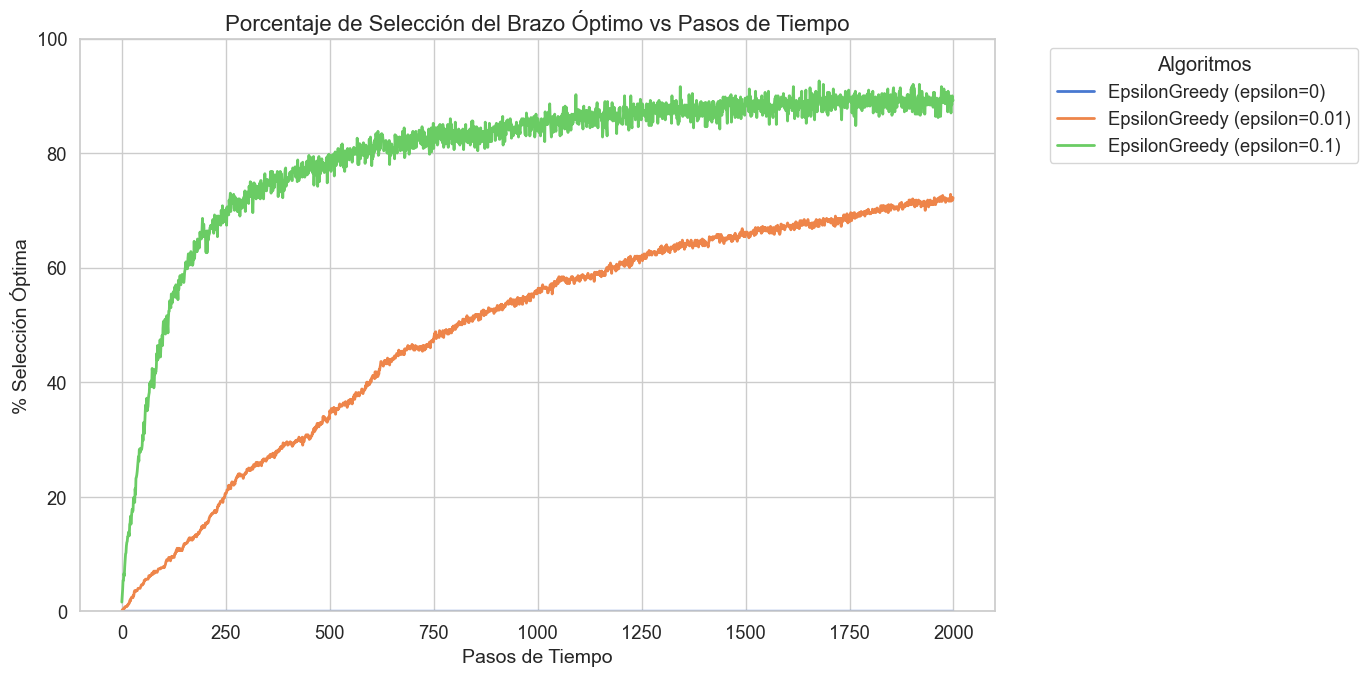

In [32]:
plot_optimal_selections(STEPS, optimal_selections_binomial, algorithms)

- **e = 0.1**: Identifica con éxito el brazo óptimo de forma acelerada, superando el 80% de selección óptima antes del paso 400 y estabilizándose en un techo cercano al 90% realizando fluctuaciones debido a la exploración aleatoria.

- **e = 0.01**: Muestra una progresión constante pero mucho más lenta, terminando la simulación cerca del 75% de selección óptima. A diferencia de la distribución normal, aquí la pendiente de aprendizaje es más suave, sugiriendo que identificar el mejor brazo binomial requiere un mayor número de muestras para diferenciar probabilidades cercanas.

- **ϵ = 0**: Su probabilidad de seleccionar el mejor brazo no mejora con el tiempo, no se visualiza así que se asume cercana a 0%. Esto confirma que, en este entorno, la exploración es indispensable para el éxito del agente.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

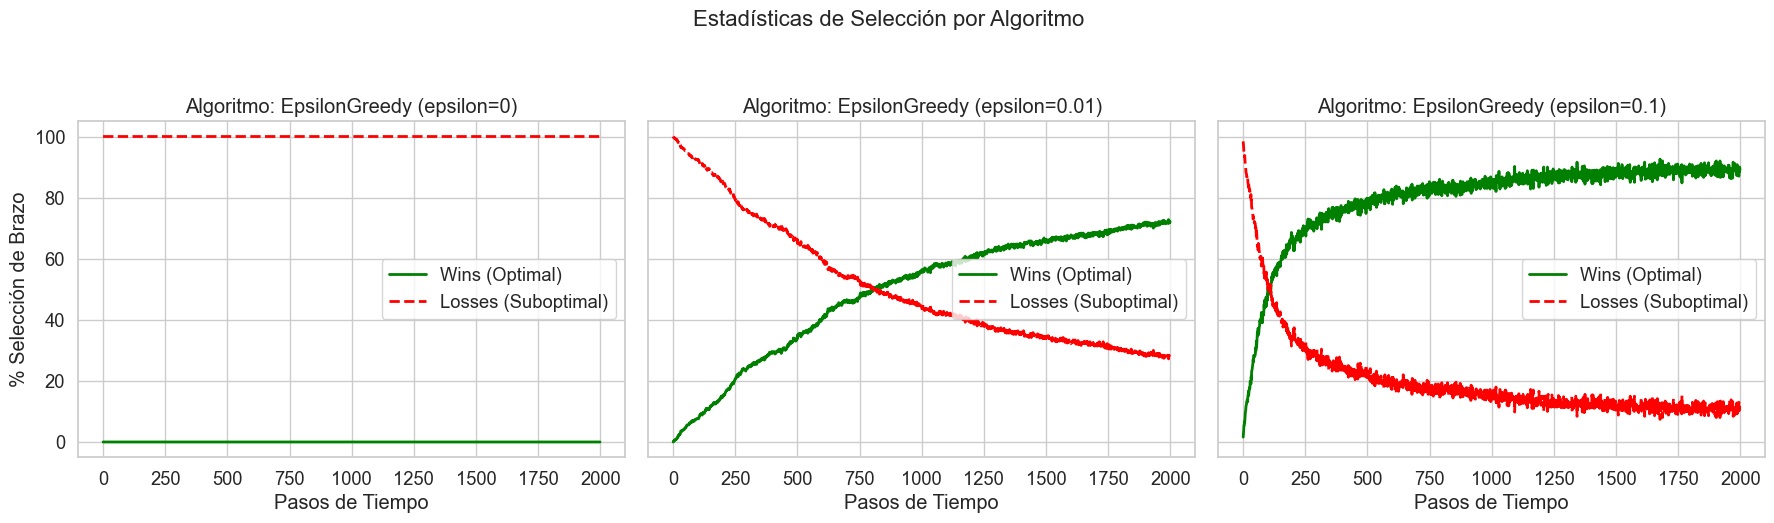

In [33]:
plot_arm_statistics(arm_stats_binomial, algorithms)

Al igual que en el experimento anterior, los valores de wins y losses son prácticamente los mismos y coinciden (evidentemente) con la gráfica de porcentaje de seleccion del brazo óptimo.

## Ejecución del experimento Bernoulli

Al igual que para el resto de distribuciones se realiza el experimento usando 10 brazos, pero para este escenario utilizamos una distribución discreta con valores entre 0 y 1. Se realizan 500 ejecuciones de 2000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [34]:
# Creación del bandit
bandido = Bandit(arms=ArmBernoulli.generate_arms(K)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_bernoulli, optimal_selections_bernoulli, arm_stats_bernoulli = run_experiment(bandido, algorithms, STEPS, RUNS)


Bandit with 10 arms: ArmBernoulli(p=0.10), ArmBernoulli(p=0.15), ArmBernoulli(p=0.19), ArmBernoulli(p=0.46), ArmBernoulli(p=0.26), ArmBernoulli(p=0.05), ArmBernoulli(p=0.39), ArmBernoulli(p=0.04), ArmBernoulli(p=0.45), ArmBernoulli(p=0.76)
Optimal arm: 10 with expected reward=0.7551914349173109


### Visualización de los resultados del experimento Bernoulli

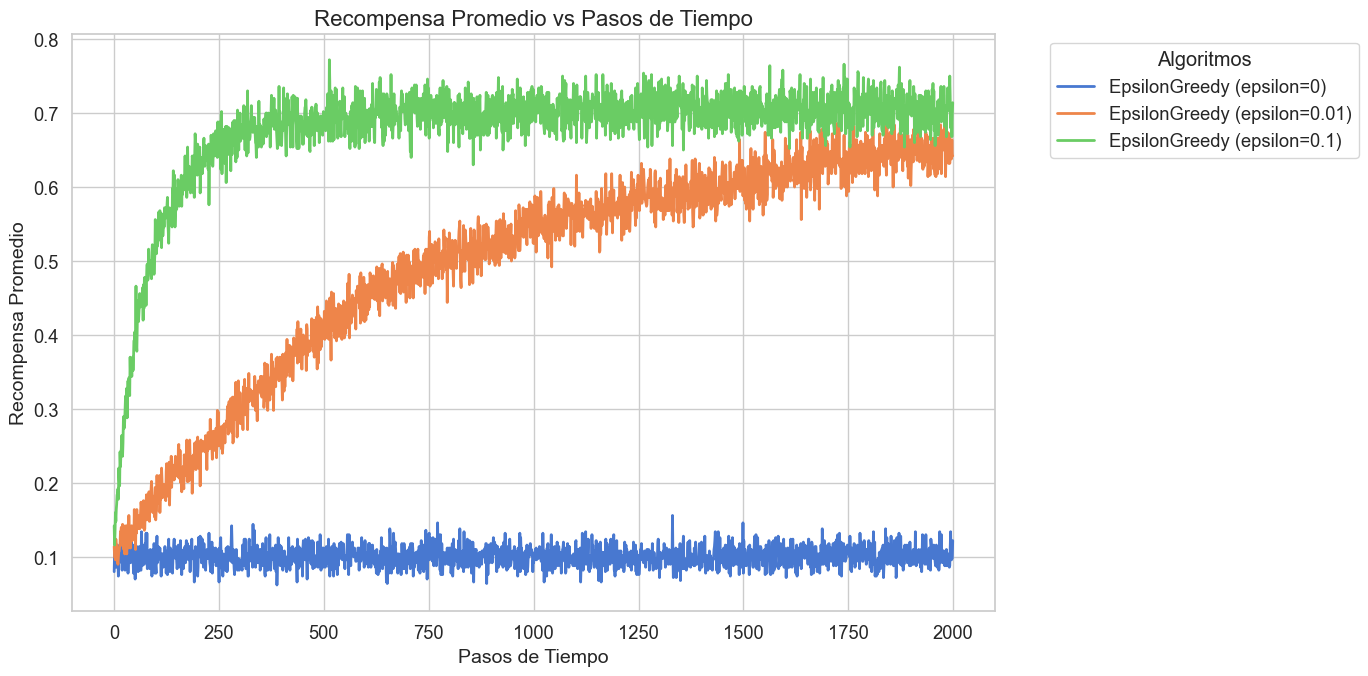

In [35]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_bernoulli, algorithms)


- **e = 0**: Se estanca casi inmediatamente en una recompensa cercana a 0.1. Debido a que las recompensas son binarias, si el primer intento de un brazo es un "fracaso" (0), el algoritmo puede descartar brazos potencialmente óptimos para siempre, quedando atrapado en un rendimiento subóptimo.

- **e = 0.1**: Logra un aprendizaje muy rápido, alcanzando un promedio de 0.7 antes del paso 500. Sin embargo, muestra una alta volatilidad (picos constantes en la gráfica). Esto se debe a que, en un entorno de 0 y 1, cada decisión de "exploración" aleatoria tiene un impacto drástico en el promedio inmediato.

- **e = 0.01**: En este caso el epsilon=0.01 no consigue ganar en recompensa promedio al valor del epsilon=0.1 para el bandido con distribucion Bernoulli, al contrario que ocurría en los casos anteriores.

---

In [36]:
print(f"optimal selections: {optimal_selections_bernoulli}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.704 0.7   0.704]
 [0.008 0.016 0.014 ... 0.914 0.914 0.906]]


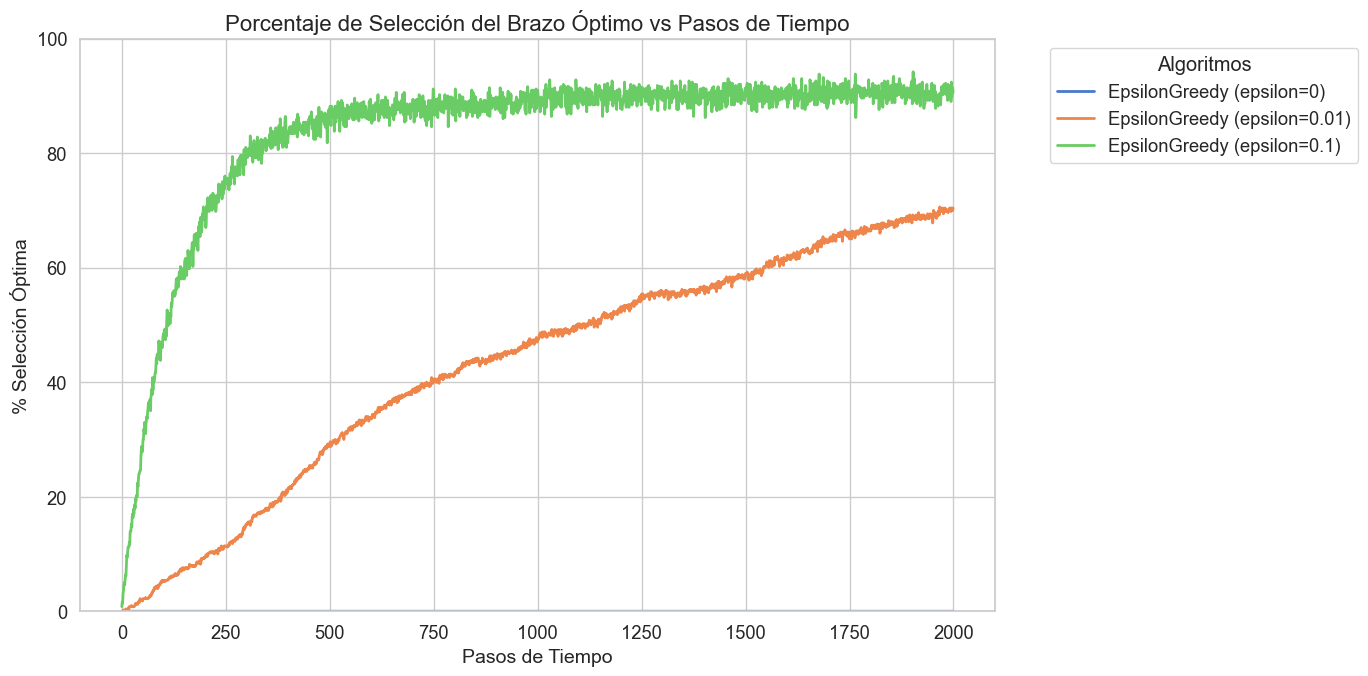

In [37]:
plot_optimal_selections(STEPS, optimal_selections_bernoulli, algorithms)

- **e = 0.1**: Es extremadamente eficaz para identificar el brazo óptimo en este entorno, estabilizándose por encima del 90% de selección óptima muy rápidamente. Esto indica que, aunque la recompensa promedio sea ruidosa, el algoritmo tiene mucha certeza sobre cuál es el mejor brazo.

- **e = 0.01**: Muestra una pendiente de mejora constante, alcanzando el 70% de selección óptima al final de los 2000 pasos. Su progresión lenta confirma que con muy poca exploración se necesitan miles de iteraciones para diferenciar estadísticamente entre una probabilidad de éxito (p) y otra.

- **e = 0**: Mantiene un porcentaje de selección óptima nulo, reforzando la idea de que en problemas de "éxito/fracaso".

### Estadisticas de Ganancia VS Pérdida por Algoritmo

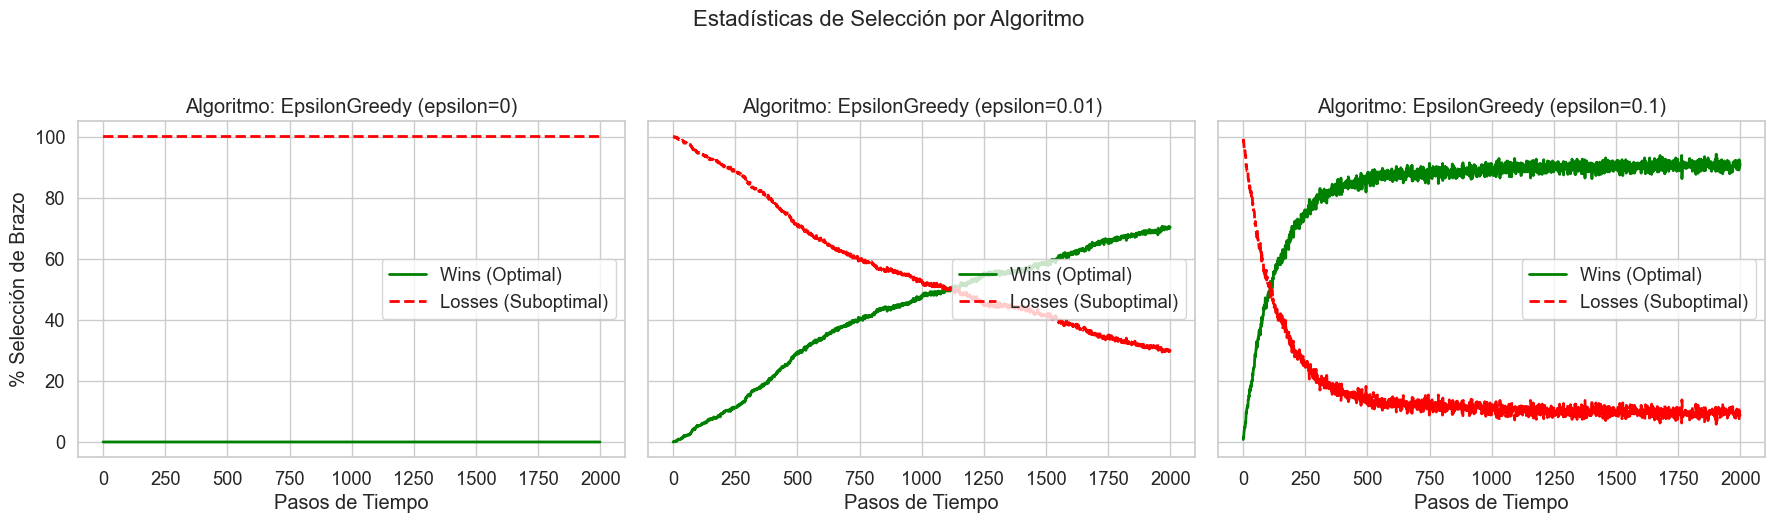

In [38]:
plot_arm_statistics(arm_stats_bernoulli, algorithms)

---

### Conclusiones Generales: Rendimiento y Estrategias

Tras analizar el comportamiento del algoritmo epsilon-Greedy en las tres Distribuciones propuestas (Normal, Binomial y Bernoulli), se extraen las siguientes conclusiones sobre el aprendizaje por refuerzo:

#### 1. El Conflicto Exploración vs. Explotacion

* **e =  0 (Fracaso sistémico):** En todas las Distribuciones, la falta de exploración condena al agente a un rendimiento bajo. Al no probar brazos diferentes, el algoritmo queda bloqueado en la primera opción que le devuelve una recompensa aceptable, ignorando sistemáticamente el brazo óptimo, a esto se le considera una convergencia prematura.
* **e =  0.1 (Velocidad):** Es la mejor opción para identificar rápidamente cuál es el mejor brazo. Sin embargo, su techo de recompensa es más bajo porque sigue perdiendo un 10 por ciento de sus acciones en exploraciones aleatorias innecesarias una vez que ya conoce el entorno.
* **e =  0.01 (Eficiencia):** Es el más eficiente a largo plazo para 2 de las 3 distribuciones de recompensas. Aunque requiere más pasos de tiempo para converger, su perdida acumulada es menor, ya que explota el brazo (que el propio algoritmo cree) óptimo el 99 por ciento del tiempo.

#### 2. Convergencia y Estabilidad según la Distribución

* **Distribución Normal:** Presenta las curvas más suaves de aprendizaje debido a la naturaleza continua de las recompensas. El agente diferencia con relativa facilidad las medias de los brazos para identificar el mejor.
* **Distribución Binomial:** El agente logra obtener recompensas promedio altas, pero la naturaleza discreta de los resultados (conteo de éxitos) genera mayor variabilidad inicial en comparación con la normal.
* **Distribución de Bernoulli:** Es el entorno más desafiante. Al recibir únicamente 1 o 0, la señal de recompensa es muy ruidosa. Aquí la exploración es más crítica que nunca, ya que un solo fracaso inicial en el brazo óptimo puede hacer que un algoritmo que explora poco lo descarte para siempre.

#### 3. Tendencias Observadas

* **Dependencia del Horizonte Temporal:** Si el experimento es corto, conviene un epsilon alto (0.1). Si el experimento es largo (más de 2000 pasos), un epsilon bajo (0.01) acabará obteniendo una recompensa acumulada mayor que el epsilon=0.1.
* **Impacto del Ruido:** A medida que pasamos a entornos binarios como Bernoulli, el algoritmo necesita más tiempo para que sus estimaciones internas de valor converjan a los valores reales de cada brazo.

---

In [39]:
# TODO Modifique los ficheros bandit_experiment.ipynb y https://github.com/ldaniel-hm/eml_k_bandit/blob/main/plotting/plotting.py para incluir en el estudio original las gráficas indicadas.

In [40]:
# TODO Cuando complete el estudio de la familia de algoritmos epsilon-greedy, indique cuál de todas las gráficas que se piden son las más relevantes ¿por qué es esa gráfica o esas gráficas las más importantes?